---

_You are currently looking at **version 1.0** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
%matplotlib inline

In [2]:
train = pd.read_csv("train.csv", engine="c", sep=',', encoding='ISO-8859-1')
train.head()

/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449.0,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN


In [3]:
train = train[train['compliance']<=1]

In [4]:
test = pd.read_csv("test.csv", engine="c", sep=',', encoding='ISO-8859-1')
test.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status
0,284932,Department of Public Works,"Granberry, Aisha B","FLUELLEN, JOHN A",10041.0,ROSEBERRY,NaN,141,ROSEBERRY,DETROIT,...,Failure to secure City or Private solid waste ...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
1,285362,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN
2,285361,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,Improper placement of Courville container betw...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN
3,285338,Department of Public Works,"Talbert, Reginald","HARABEDIEN, POPKIN",1835.0,CENTRAL,NaN,2246,NELSON,WOODHAVEN,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
4,285346,Department of Public Works,"Talbert, Reginald","CORBELL, STANLEY",1700.0,CENTRAL,NaN,3435,MUNGER,LIVONIA,...,Violation of time limit for approved container...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159880 entries, 0 to 250293
Data columns (total 34 columns):
ticket_id                     159880 non-null int64
agency_name                   159880 non-null object
inspector_name                159880 non-null object
violator_name                 159854 non-null object
violation_street_number       159880 non-null float64
violation_street_name         159880 non-null object
violation_zip_code            0 non-null float64
mailing_address_str_number    157322 non-null float64
mailing_address_str_name      159877 non-null object
city                          159880 non-null object
state                         159796 non-null object
zip_code                      159879 non-null object
non_us_str_code               3 non-null object
country                       159880 non-null object
ticket_issued_date            159880 non-null object
hearing_date                  159653 non-null object
violation_code                159880 non-null obj

In [6]:
train['ticket_issued_date'] = pd.to_datetime(train['ticket_issued_date'])
train['hearing_date'] = pd.to_datetime(train['hearing_date'])

In [7]:
test['ticket_issued_date'] = pd.to_datetime(test['ticket_issued_date'])
test['hearing_date'] = pd.to_datetime(test['hearing_date'])

In [8]:
print("train df is from: ", train['ticket_issued_date'].min()," to ", train['ticket_issued_date'].max())

train df is from:  1988-05-06 20:00:00  to  2011-12-30 14:20:00


In [9]:
train = train[train['ticket_issued_date']>='2004-01-01']

In [10]:
train.describe()

,ticket_id,violation_street_number,violation_zip_code,mailing_address_str_number,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,compliance
count,159879.000000,1.598790e+05,0.0,1.573210e+05,159879.000000,159879.0,159879.0,159879.000000,159879.000000,159879.0,159879.000000,159879.000000,159879.000000,159879.000000
mean,150453.382064,1.071322e+04,NaN,9.133656e+03,357.037216,20.0,10.0,33.651692,0.195961,0.0,420.652317,72.206457,348.265463,0.072530
std,77224.657123,3.623169e+04,NaN,3.657740e+04,675.657256,0.0,0.0,67.693090,4.290357,0.0,742.556910,259.850356,729.297461,0.259364
min,18645.000000,0.000000e+00,NaN,1.000000e+00,0.000000,20.0,10.0,0.000000,0.000000,0.0,0.000000,0.000000,-7750.000000,0.000000
25%,83370.500000,4.920000e+03,NaN,5.320000e+02,200.000000,20.0,10.0,10.000000,0.000000,0.0,250.000000,0.000000,85.000000,0.000000
50%,149777.000000,1.039800e+04,NaN,2.418000e+03,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000
75%,217479.500000,1.578350e+04,NaN,1.284400e+04,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000
max,299363.000000,1.415411e+07,NaN,5.111345e+06,10000.000000,20.0,10.0,1000.000000,350.000000,0.0,11030.000000,11030.000000,11030.000000,1.000000


In [11]:
print("test df is from: ", test['ticket_issued_date'].min()," to ", test['ticket_issued_date'].max())

test df is from:  2012-01-04 14:00:00  to  2016-12-29 15:00:00


In [12]:
test.describe()

,ticket_id,violation_street_number,non_us_str_code,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount
count,61001.000000,6.100100e+04,0.0,61001.000000,61001.0,61001.0,61001.000000,61001.000000,61001.000000,61001.000000
mean,331724.532811,1.256638e+04,NaN,272.714185,20.0,10.0,25.116219,0.239340,20.649711,347.895541
std,25434.932141,1.414373e+05,NaN,360.101855,0.0,0.0,36.310155,3.245894,242.375180,460.058043
min,284932.000000,-1.512600e+04,NaN,0.000000,20.0,10.0,0.000000,0.000000,0.000000,0.000000
25%,310111.000000,6.008000e+03,NaN,50.000000,20.0,10.0,5.000000,0.000000,0.000000,85.000000
50%,332251.000000,1.213400e+04,NaN,200.000000,20.0,10.0,10.000000,0.000000,0.000000,250.000000
75%,353031.000000,1.716500e+04,NaN,250.000000,20.0,10.0,25.000000,0.000000,0.000000,305.000000
max,376698.000000,2.010611e+07,NaN,10000.000000,20.0,10.0,1000.000000,250.000000,15309.000000,15558.800000


In [13]:
train.shape

(159879, 34)

In [14]:
test.shape

(61001, 27)

In [15]:
train_only_col = ['payment_amount', 'payment_date', 'payment_status', 'balance_due', 'collection_status', 'compliance_detail']

In [16]:
train.drop(train_only_col, axis=1, inplace=1)

Percentage of missing values

In [17]:
(np.sum(train.isnull())/len(train['ticket_id']))

ticket_id                     0.000000
agency_name                   0.000000
inspector_name                0.000000
violator_name                 0.000163
violation_street_number       0.000000
violation_street_name         0.000000
violation_zip_code            1.000000
mailing_address_str_number    0.016000
mailing_address_str_name      0.000019
city                          0.000000
state                         0.000525
zip_code                      0.000006
non_us_str_code               0.999981
country                       0.000000
ticket_issued_date            0.000000
hearing_date                  0.001420
violation_code                0.000000
violation_description         0.000000
disposition                   0.000000
fine_amount                   0.000000
admin_fee                     0.000000
state_fee                     0.000000
late_fee                      0.000000
discount_amount               0.000000
clean_up_cost                 0.000000
judgment_amount          

In [18]:
missing_data_col = ['grafitti_status','violation_zip_code']

In [19]:
train.drop(missing_data_col, inplace=True, axis=1)

In [20]:
test.drop(missing_data_col, inplace=True, axis=1)

## EDA

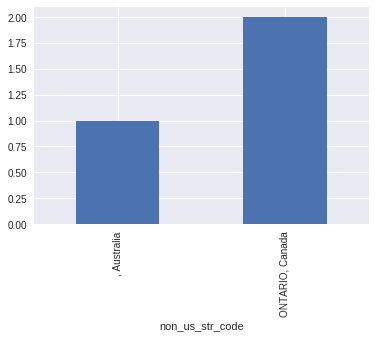

In [21]:
train.groupby(['non_us_str_code']).mean()['compliance'].plot.bar()
train.groupby(['non_us_str_code']).count()['compliance'].plot.bar() # this doesn't give us enough data to learn

In [22]:
del train['non_us_str_code']
del test['non_us_str_code']

In [23]:
train['agency_name'].unique()

array(['Buildings, Safety Engineering & Env Department',
       'Health Department', 'Department of Public Works',
       'Detroit Police Department', 'Neighborhood City Halls'], dtype=object)

In [24]:
test['agency_name'].unique()

array(['Department of Public Works',
       'Buildings, Safety Engineering & Env Department',
       'Detroit Police Department'], dtype=object)

In [25]:
def agency_name(x):
    if 'buildings' in x.lower():
        return 'Buildings'
    elif 'health' in x.lower():
        return 'Health'
    elif 'public' in x.lower():
        return 'Public Work'
    elif 'police' in x.lower():
        return 'Police'
    elif 'halls' in x.lower():
        return 'Neighborhood'
train['agency_name'] = train['agency_name'].map(agency_name)

In [26]:
test['agency_name'] = test['agency_name'].map(agency_name)

In [27]:
''' to create a dummy variable for common values in the same columns of each df'''
def dummy_common(train_df, test_df, column):
    #column: is the columns for which dummy is to be created
    col_names = list(set(train_df[column]) & set(test_df[column]));
    for col in col_names:
        train_df[col] = train_df[column].map(lambda x: 1 if x==col else 0)
        test_df[col] = test_df[column].map(lambda x: 1 if x==col else 0)
    del train_df[column]
    del test_df[column]
    return (train_df,test_df);

In [28]:
train, test = dummy_common(train, test, 'agency_name')

In [29]:
train['disposition'].unique()

array(['Responsible by Default', 'Responsible by Determination',
       'Responsible by Admission', 'Responsible (Fine Waived) by Deter'], dtype=object)

In [30]:
test['disposition'].unique()

array(['Responsible by Default', 'Responsible by Determination',
       'Responsible by Admission', 'Responsible (Fine Waived) by Deter',
       'Responsible (Fine Waived) by Admis',
       'Responsible - Compl/Adj by Default',
       'Responsible - Compl/Adj by Determi', 'Responsible by Dismissal'], dtype=object)

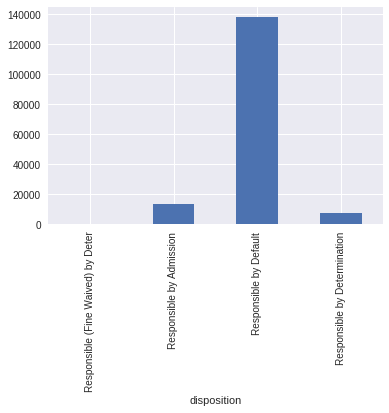

In [31]:
train.groupby('disposition')['ticket_id'].count().plot.bar();

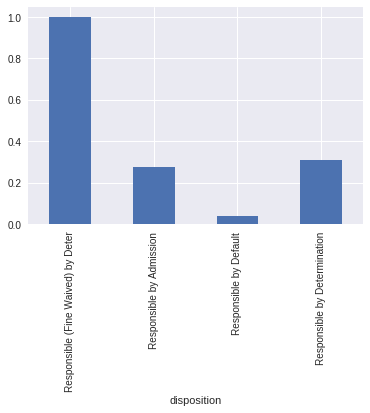

In [32]:
train.groupby('disposition')['compliance'].mean().plot.bar()

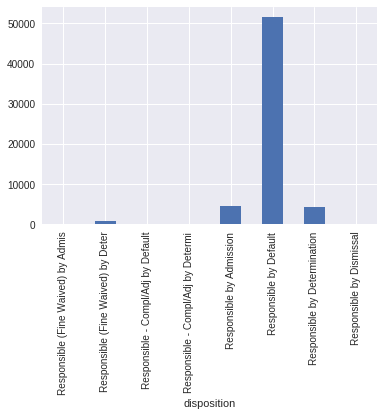

In [33]:
test.groupby('disposition').count()['ticket_id'].plot.bar();

In [34]:
def disposition(x):
    if 'fine waved' in x.lower():
        return 'fine_waved'
    elif 'determination' in x.lower():
        return 'determination'
    elif 'default' in x.lower():
        return 'default'
    elif 'admission' in x.lower():
        return 'admission'
    else:
        return 'other'

In [35]:
train['disposition'] = train['disposition'].map(disposition)

In [36]:
test['disposition'] = test['disposition'].map(disposition)

In [37]:
train, test = dummy_common(train, test, 'disposition')

In [38]:
train.columns

Index(['ticket_id', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'mailing_address_str_number', 'mailing_address_str_name', 'city',
       'state', 'zip_code', 'country', 'ticket_issued_date', 'hearing_date',
       'violation_code', 'violation_description', 'fine_amount', 'admin_fee',
       'state_fee', 'late_fee', 'discount_amount', 'clean_up_cost',
       'judgment_amount', 'compliance', 'Buildings', 'Police', 'Public Work',
       'admission', 'default', 'other', 'determination'],
      dtype='object')

In [39]:
train[['violation_code', 'violation_description']].head() # we can remove the digits after last - or '.',
# as the violation code are section and article wise and then sub articles. 

,violation_code,violation_description
0,9-1-36(a),Failure of owner to obtain certificate of comp...
1,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...
5,9-1-36(a),Failure of owner to obtain certificate of comp...
6,61-63.0500,Failed To Secure Permit For Lawful Use Of Land
7,61-63.0100,Noncompliance/Grant Condition/BZA/BSE


In [40]:
train['violation_code'].unique()

array(['9-1-36(a)', '61-63.0600', '61-63.0500', '61-63.0100', '9-1-103(C)',
       '22-2-83(a)(b)(c)', '22-2-21(b)', '9-1-36(c)', '22-2-17', '22-2-23',
       '61-47.0000/47.0108', '61-90.0100', '22-2-88', '19450901',
       '22-2-43', '9-1-355', '22-2-83', '22-2-22', '22-2-45', '9-1-110(a)',
       '22-2-88(a)', '9-1-104', '9-1-105', '22-2-61', '9-1-201(a)',
       '9-1-209', '61-130.0000/130.0400', '22-2-41', '9-1-101',
       '9-1-43(a) - (Dwellin', '9-1-205', '9-1-206', '9-1-107',
       '9-1-201(b)', '9-1-210', '9-1-220', '20130901', '9-1-214',
       '9-1-103 (a) or (b)', '9-1-477', '9-1-211', '9-1-204', '9-1-310',
       '9-1-208', '9-1-81(a)', '9-1-476', '22-2-44', '9-1-303', '22-2-49',
       '9-1-111', '22-2-16', '9-1-221', '22-2-20', '9-1-36(d)',
       '61-80.0100', '9-1-106', '9-1-108', '9-1-43(a) - (Structu',
       '61-82.0100/32.0066', '61-81.0100/45.0807', '22-2-84(a)(1)(2)(4)',
       '22-2-87(a)', '22-2-56', '19830901', '61-81.0100/32.0066',
       '61-130.0000/130.0

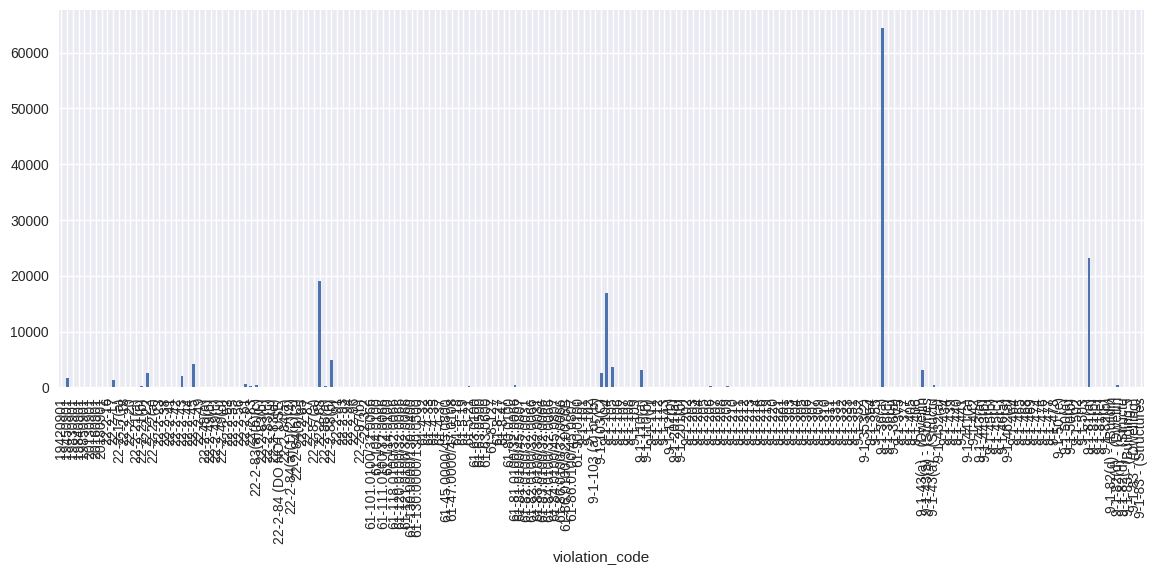

In [41]:
train.groupby('violation_code')['compliance'].count().plot.bar()
fig = plt.gcf();
fig.set_size_inches(14,5);
fig.set_dpi(100);

In [42]:
train['violation_code'] = train['violation_code'].map(lambda x: "-".join(x.split('-')[0:2]).split('.')[0]) # since there are many dates we will have to leave this columns. This dates could be probable mistake in entry

In [43]:
test['violation_code'] = test['violation_code'].map(lambda x: "-".join(x.split('-')[0:2]).split('.')[0]) # since there are many dates we will have to leave this columns. This dates could be probable mistake in entry

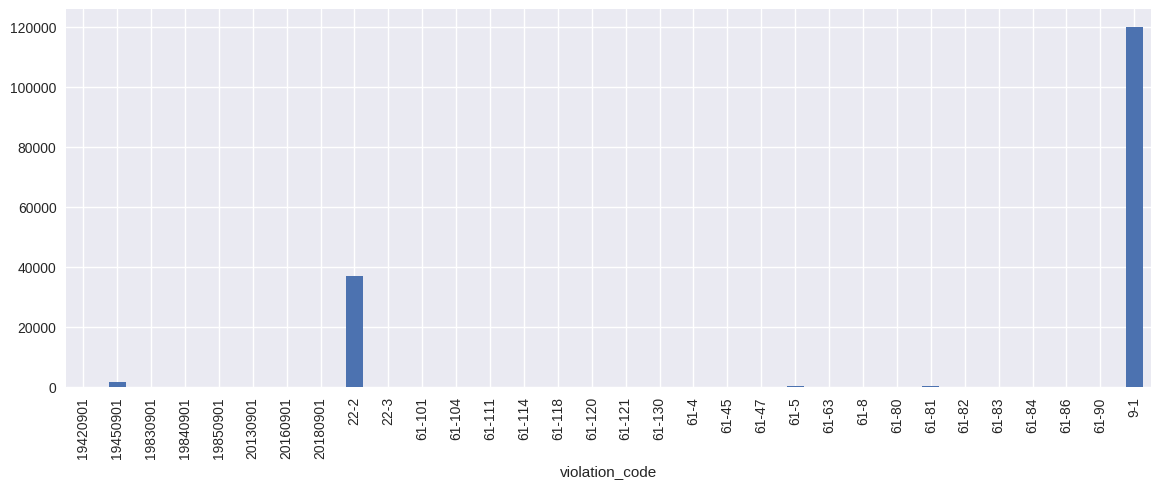

In [44]:
train.groupby('violation_code')['compliance'].count().plot.bar()
fig = plt.gcf();
fig.set_size_inches(14,5);
fig.set_dpi(100);

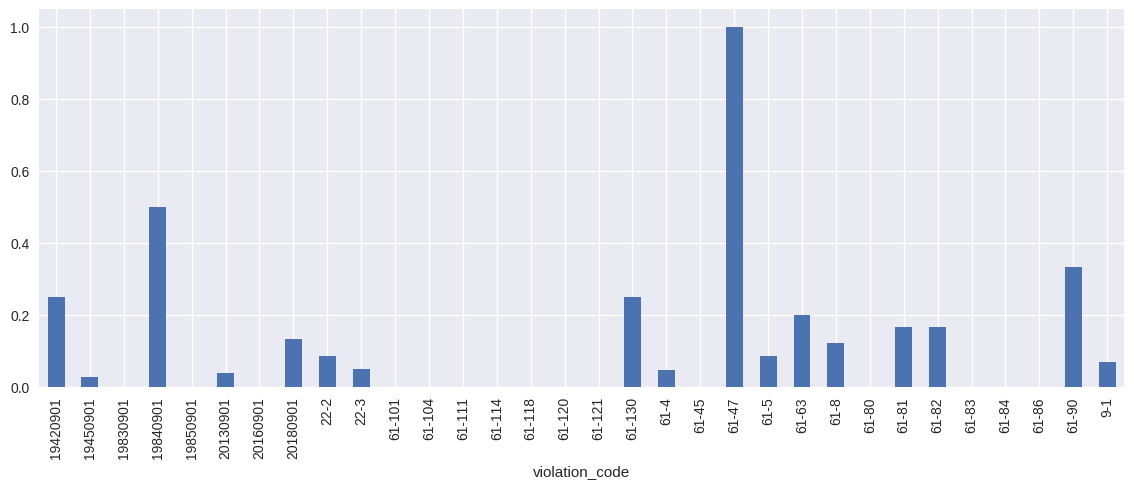

In [45]:
train.groupby('violation_code')['compliance'].mean().plot.bar()
fig = plt.gcf();
fig.set_size_inches(14,5);
fig.set_dpi(100);

In [46]:
test['violation_code'] = test['violation_code'].map(lambda x: 'other' if len(x) > 4 else x.split('-')[0])

In [47]:
train['violation_code'] = train['violation_code'].map(lambda x: 'other' if len(x) > 4 else x.split('-')[0])

In [48]:
train['time_gap'] = (train['hearing_date']-train['ticket_issued_date']).dt.days+1;
train['time_gap'] 

0         370.0
1         379.0
5         324.0
6         254.0
7         252.0
8         252.0
9         324.0
12        210.0
13        202.0
14        190.0
18        139.0
19        139.0
21        191.0
22        190.0
23        216.0
26         41.0
28         25.0
30         31.0
31         31.0
33         69.0
34         32.0
35         36.0
37         36.0
38         31.0
39         36.0
40         31.0
41         40.0
42         22.0
43         36.0
44         31.0
          ...  
250244   -279.0
250249   -223.0
250250   -294.0
250254   -279.0
250255   -279.0
250256   -293.0
250257     14.0
250258     20.0
250259     20.0
250261     20.0
250262     20.0
250264     31.0
250265     45.0
250266     31.0
250267     31.0
250268     38.0
250269     38.0
250270     38.0
250271     38.0
250272     31.0
250273     31.0
250274     31.0
250275     30.0
250276     30.0
250277     30.0
250278     38.0
250287     11.0
250288     27.0
250290     41.0
250293      6.0
Name: time_gap, dtype: f

In [49]:
train[train['time_gap']<0][['ticket_issued_date','hearing_date']] #deleting these values since hearing date can't be before issue date

,ticket_issued_date,hearing_date
81036,2006-12-28 13:15:00,2006-12-20 10:30:00
124408,2007-12-27 15:00:00,2007-12-20 10:30:00
124416,2007-12-30 13:45:00,2007-12-13 10:30:00
137576,2008-03-27 13:10:00,2008-03-18 10:30:00
137577,2008-03-27 13:10:00,2008-03-18 10:30:00
137650,2008-03-27 13:25:00,2008-03-18 10:30:00
137651,2008-03-27 13:25:00,2008-03-18 10:30:00
137660,2008-03-27 09:00:00,2008-03-17 09:00:00
137661,2008-03-27 09:00:00,2008-03-17 09:00:00
137683,2008-03-27 13:35:00,2008-03-18 10:30:00


In [50]:
test['time_gap'] = (test['hearing_date']-test['ticket_issued_date']).dt.days+1;

In [51]:
train = train[train['time_gap']>=0]
test = test[test['time_gap']>=0]

In [52]:
np.sum(test.isnull())

ticket_id                        0
inspector_name                   0
violator_name                   28
violation_street_number          0
violation_street_name            0
mailing_address_str_number    1008
mailing_address_str_name         3
city                             1
state                          327
zip_code                         3
country                          0
ticket_issued_date               0
hearing_date                     0
violation_code                   0
violation_description            0
fine_amount                      0
admin_fee                        0
state_fee                        0
late_fee                         0
discount_amount                  0
clean_up_cost                    0
judgment_amount                  0
Buildings                        0
Police                           0
Public Work                      0
admission                        0
default                          0
other                            0
determination       

In [53]:
np.sum(train.isnull())

ticket_id                        0
inspector_name                   0
violator_name                   26
violation_street_number          0
violation_street_name            0
mailing_address_str_number    2550
mailing_address_str_name         3
city                             0
state                           84
zip_code                         0
country                          0
ticket_issued_date               0
hearing_date                     0
violation_code                   0
violation_description            0
fine_amount                      0
admin_fee                        0
state_fee                        0
late_fee                         0
discount_amount                  0
clean_up_cost                    0
judgment_amount                  0
compliance                       0
Buildings                        0
Police                           0
Public Work                      0
admission                        0
default                          0
other               

##### trying to get some meaningful out of  inspector name, since outcome can be based on Inspector judgement. 

In [54]:
train['inspector_name'] = train['inspector_name'].map(lambda x: x.lower())
test['inspector_name'] = test['inspector_name'].map(lambda x: x.lower())

In [55]:
avg_compliance = train.groupby('compliance').count()['ticket_id']/len(train['compliance'])
x = pd.DataFrame(train.groupby(['inspector_name','compliance']).count()['ticket_id']/train.groupby(['inspector_name']).count()['ticket_id']).reset_index()
x['compliance_by_inspector'] = None
for i in [0,1]:
    x.loc[(x['compliance']==i)&((x['ticket_id']>=avg_compliance[i]*1.3)|(x['ticket_id']<=avg_compliance[i]*0.7)), 'compliance_by_inspector']=i
x = x.join(pd.get_dummies(x['compliance_by_inspector']))
for i in [0,1]:
    x.rename(columns={i:'compliance_by_inspector_{}'.format(i)}, inplace=True)
x.drop(['compliance_by_inspector','compliance','ticket_id'], axis=1, inplace=True)
x = x.groupby('inspector_name').sum().reset_index()
train=train.merge(x, on='inspector_name', how='inner')

In [56]:
test=test.merge(x, on='inspector_name', how='left')

In [57]:
train.drop('inspector_name',axis=1, inplace=True)
test.drop('inspector_name',axis=1, inplace=True)

In [58]:
train.groupby('compliance').mean()['fine_amount']

compliance
0.0    366.142016
1.0    236.433599
Name: fine_amount, dtype: float64

In [59]:
train.loc[train['fine_amount'].isnull(), 'fine_amount'] = 0
test.loc[test['fine_amount'].isnull(), 'fine_amount'] = 0

In [60]:
train.drop('country', axis=1, inplace=True)
test.drop('country', axis=1, inplace=True)

In [61]:
train['city'] = train['city'].map(lambda x: x.lower())
test['city'] = test['city'].map(lambda x: str(x).lower())

In [62]:
train['from_detroit'] = train['city'].map(lambda x: 1 if x=='detroit' else 0)
test['from_detroit'] = test['city'].map(lambda x: 1 if x=='detroit' else 0)

In [63]:
#train.drop(['admin_fee', 'state_fee', 'late_fee', 'discount_amount', 'clean_up_cost', 'judgment_amount'], axis=1, inplace=True)


In [64]:
train = train[['ticket_id','fine_amount', 'admin_fee', 'state_fee',
       'late_fee', 'discount_amount', 'clean_up_cost', 'judgment_amount',
       'compliance','Public Work', 'Buildings', 'Police', 'admission',
       'default', 'other', 'determination', 'time_gap',
       'compliance_by_inspector_0', 'compliance_by_inspector_1',
       'from_detroit']].set_index('ticket_id')

In [65]:
submission = test[['ticket_id','fine_amount', 'admin_fee', 'state_fee',
       'late_fee', 'discount_amount', 'clean_up_cost', 'judgment_amount',
       'Public Work', 'Buildings', 'Police', 'admission',
       'default', 'other', 'determination', 'time_gap',
       'compliance_by_inspector_0', 'compliance_by_inspector_1',
       'from_detroit']].set_index('ticket_id')

In [66]:
np.sum(train.isnull())

fine_amount                  0
admin_fee                    0
state_fee                    0
late_fee                     0
discount_amount              0
clean_up_cost                0
judgment_amount              0
compliance                   0
Public Work                  0
Buildings                    0
Police                       0
admission                    0
default                      0
other                        0
determination                0
time_gap                     0
compliance_by_inspector_0    0
compliance_by_inspector_1    0
from_detroit                 0
dtype: int64

In [67]:
np.sum(submission.isnull())

fine_amount                      0
admin_fee                        0
state_fee                        0
late_fee                         0
discount_amount                  0
clean_up_cost                    0
judgment_amount                  0
Public Work                      0
Buildings                        0
Police                           0
admission                        0
default                          0
other                            0
determination                    0
time_gap                         0
compliance_by_inspector_0    16874
compliance_by_inspector_1    16874
from_detroit                     0
dtype: int64

In [68]:
submission.fillna(0, inplace=True)

In [69]:
np.sum(submission.isnull())

fine_amount                  0
admin_fee                    0
state_fee                    0
late_fee                     0
discount_amount              0
clean_up_cost                0
judgment_amount              0
Public Work                  0
Buildings                    0
Police                       0
admission                    0
default                      0
other                        0
determination                0
time_gap                     0
compliance_by_inspector_0    0
compliance_by_inspector_1    0
from_detroit                 0
dtype: int64

In [89]:
train_sample = train.sample(frac=0.05)

In [90]:
X_train = train_sample.drop('compliance', axis=1);
y_train = train_sample['compliance'];

In [91]:
def plot_learning_curve(est, X_train, y_train,train_sizes = np.linspace(.1, 1.0, 5)):
    import matplotlib.pyplot as plt
    from sklearn.learning_curve import learning_curve
    train_size, train_score, CV_score = learning_curve(est, X_train, y_train,
                                                       train_sizes=train_sizes, scoring = 'roc_auc');
    plt.figure();
    plt.plot(train_size, np.mean(train_score, axis=1), 'o-', color='b', label='training score');
    plt.plot(train_size, np.mean(CV_score, axis=1), 'o-', color='r', label='CV score');
    plt.xlabel("Training examples");
    plt.ylabel("Score");
    plt.fill_between(train_size, np.mean(train_score, axis=1) - np.std(train_score, axis=1),
                     np.mean(train_score, axis=1) + np.std(train_score, axis=1), alpha=0.1,
                     color="b");
    plt.fill_between(train_size, np.mean(CV_score, axis=1) - np.std(CV_score, axis=1),
                     np.mean(CV_score, axis=1) + np.std(CV_score, axis=1), alpha=0.1,
                     color="r");
    plt.title("Learning Curve", fontsize=20);
    plt.legend();
    plt.show();

In [92]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import RandomForestClassifier

In [93]:
'''param_logit = {'C':[0.01,0.1,1,10,100], 'penalty':['l1','l2']}
#param_knn = {'n_neighbors':[1,3,6,10], 'weights':['uniform','distance']}
param_svc = {'C':[0.01,0.1,1,10,100], 'kernel':{'rbf','sigmoid','precomputed'}}
#param_ann = {hidden_layer_sizes}
param_rfc = {'n_estimator':[2,3,6,8,10], 'max_features':[10,100,500,1000]}'''

"param_logit = {'C':[0.01,0.1,1,10,100], 'penalty':['l1','l2']}\n#param_knn = {'n_neighbors':[1,3,6,10], 'weights':['uniform','distance']}\nparam_svc = {'C':[0.01,0.1,1,10,100], 'kernel':{'rbf','sigmoid','precomputed'}}\n#param_ann = {hidden_layer_sizes}\nparam_rfc = {'n_estimator':[2,3,6,8,10], 'max_features':[10,100,500,1000]}"

In [94]:
model_list = [LogisticRegression(), KNeighborsClassifier(), SVC(), RandomForestClassifier(),AdaBoostClassifier()];

learning curve for	LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


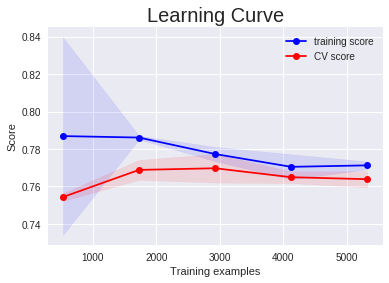

learning curve for	KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')


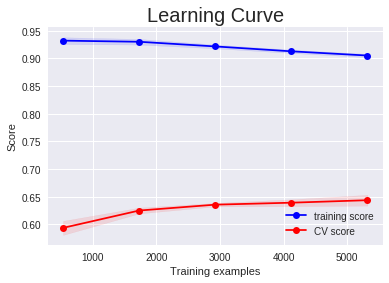

learning curve for	SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


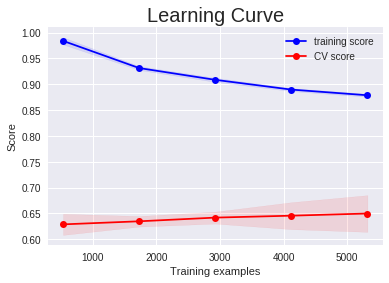

learning curve for	RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


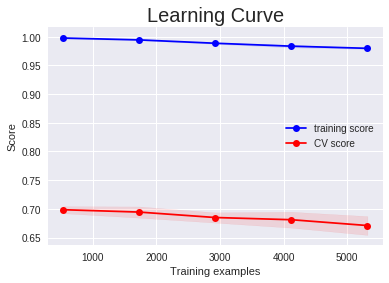

learning curve for	AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


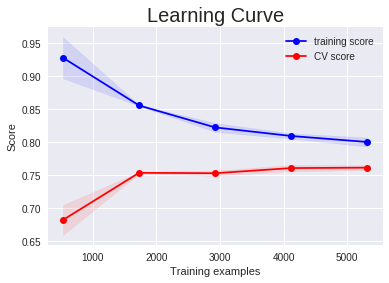

In [95]:
for model in model_list:
    #gscv = GridSearchCV(model, param, scoring='roc_auc');
    print("learning curve for\t{}".format(model))
    plot_learning_curve(model, X_train, y_train)

## Logistic Regression

In [104]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop('compliance', axis=1), train['compliance'])

In [108]:
param_logit = {'C':[0.01,0.1,1,10,100],  
               'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag'],
               'tol':[1e-2,1e-4,1e-6,1e-8],
               'n_jobs':[-1]}
gscv = GridSearchCV(LogisticRegression(), param_logit, scoring='roc_auc')
gscv.fit(train_sample.drop('compliance', axis=1),train_sample['compliance'])
gscv.best_params_

/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

{'C': 0.01, 'n_jobs': -1, 'solver': 'newton-cg', 'tol': 0.0001}

In [110]:
model = LogisticRegression(C= 0.01, n_jobs= -1, solver= 'newton-cg', tol= 0.0001)
model.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [128]:
from sklearn.metrics import auc, roc_curve

In [123]:
y_true = model.predict_proba(X_test)[:,1]

In [125]:
fpr, tpr, thresholds = roc_curve(y_test, y_true)

In [129]:
auc = auc(fpr, tpr)

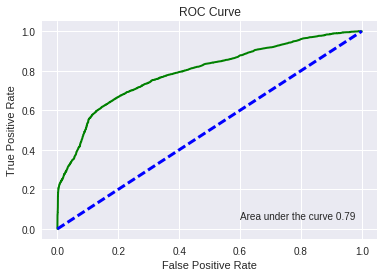

In [130]:
plt.plot(fpr, tpr, 'g-', lw=2)
plt.plot([0,1],[0,1],'b--',lw=3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.gca().text(0.6, 0.05, "Area under the curve {}".format(np.round(auc, 2)))

In [131]:
submission.shape

(58706, 18)

In [133]:
pro = model.predict_proba(submission)[:,1]

/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [137]:
sub_df = pd.DataFrame(pro, submission.index)

In [138]:


def blight_model():
    
    # Your code here
    
    return sub_df